In [1]:
# Tyler Edwards
# Professional League of Legends Champion Network

# Takes data from League of Legends pro matches and creates a network of champions played linked together by teams they were on.

import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
import pandas as pd
import os


In [2]:
# Data is from Oracle's Exlixir Google drive.
file = "2023_LoL_esports_match_data_from_OraclesElixir.csv"
df = pd.read_csv(file)

# *** Change "scope" to the league, team, or patch you want to filter the data for, and uncomment the appropriate filter below.
# Commenting out 
scope = 'T1' # Region/Team/patch/etc.

df = df[df['league'] == "WLDs"]
# df = df[df['teamname'] == scope]
df = df[df['patch'] == 13.19] # Excluding anything before play-ins

# Removing the aggregated team rows
teamrows = df["position"] == "team"
df = df.drop(df[teamrows].index)

# Creating an ID for each game + which team they were on that game
df["gameside"] = df["gameid"] + "|" + df["side"]
print(df.shape)
df.head(10)

(70, 124)


C:\Users\Ty\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,gameside
123720,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,-2703.0,-1497.0,-11.0,0.0,0.0,2.0,4.0,0.0,0.0,ESPORTSTMNT06_2827798|Blue
123721,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,-285.0,352.0,14.0,0.0,2.0,2.0,0.0,5.0,1.0,ESPORTSTMNT06_2827798|Blue
123722,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,-2271.0,-689.0,-14.0,0.0,0.0,3.0,3.0,4.0,0.0,ESPORTSTMNT06_2827798|Blue
123723,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,-713.0,-937.0,-27.0,2.0,0.0,1.0,1.0,1.0,1.0,ESPORTSTMNT06_2827798|Blue
123724,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,-47.0,37.0,7.0,0.0,2.0,0.0,0.0,3.0,0.0,ESPORTSTMNT06_2827798|Blue
123725,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,2703.0,1497.0,11.0,4.0,0.0,0.0,0.0,0.0,2.0,ESPORTSTMNT06_2827798|Red
123726,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,285.0,-352.0,-14.0,0.0,5.0,1.0,0.0,2.0,2.0,ESPORTSTMNT06_2827798|Red
123727,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,2271.0,689.0,14.0,3.0,4.0,0.0,0.0,0.0,3.0,ESPORTSTMNT06_2827798|Red
123728,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,713.0,937.0,27.0,1.0,1.0,1.0,2.0,0.0,1.0,ESPORTSTMNT06_2827798|Red
123729,ESPORTSTMNT06_2827798,complete,NaN,WLDs,2023,NaN,0,2023-10-09 04:09:51,1,13.19,...,47.0,-37.0,-7.0,0.0,3.0,0.0,0.0,2.0,0.0,ESPORTSTMNT06_2827798|Red


In [3]:
# Dataframe with only relevant columns
df2 = df[['champion', 'position']]

# Dataframe to assign a role to each node (Champion)
# Some champions are played in multiple roles but we're just taking the one they were played in the most.
df2count = df.groupby(["champion", "position"]).size().reset_index(name="count")
df2count = df2count.sort_values(by=['count'], ascending=False)
df2count = df2count.drop_duplicates(subset="champion", keep='first')

df2 = df2.drop_duplicates(subset='champion', keep="first")
print(df2.shape)

# Dictionary of Champions and their roles
roles = dict(zip(df2count['champion'], df2count['position']))

# Changing roles to colors for the network node colors.
for key, val in roles.items():
    if val == 'top':
        roles[key] = 'deepskyblue'
    elif val == 'jng':
        roles[key] = 'lime'
    elif val == 'mid':
        roles[key] = 'magenta'
    elif val == 'bot':
        roles[key] = 'orange'
    elif val == 'sup':
        roles[key] = 'yellow'


(32, 2)


In [4]:
# Dataframe for network
df3 = pd.DataFrame(columns = ["champion1", "champion2"])
   
# For each 'gameside' there is a row made for every combination of two champions on that team.
for i in df.gameside.unique():
    team_df = df.loc[(df['gameside'] == i)]
    team_comp = team_df["champion"]
    combinations = [(a, b) for idx, a in enumerate(team_comp) for b in team_comp[idx + 1:]]
    for i in combinations:
        new_row = {"champion1": i[0], "champion2": i[1]}
        df3.loc[len(df3)] = new_row
        
print(df3.shape)
df3.head(10)


(140, 2)


,champion1,champion2
0,K'Sante,Taliyah
1,K'Sante,Yone
2,K'Sante,Kai'Sa
3,K'Sante,Amumu
4,Taliyah,Yone
5,Taliyah,Kai'Sa
6,Taliyah,Amumu
7,Yone,Kai'Sa
8,Yone,Amumu
9,Kai'Sa,Amumu


In [5]:
# Creating network and graphs

G = nx.from_pandas_edgelist(df3, 'champion1', 'champion2', create_using=nx.Graph())
d = dict(G.degree)

0.2399193548387097
4


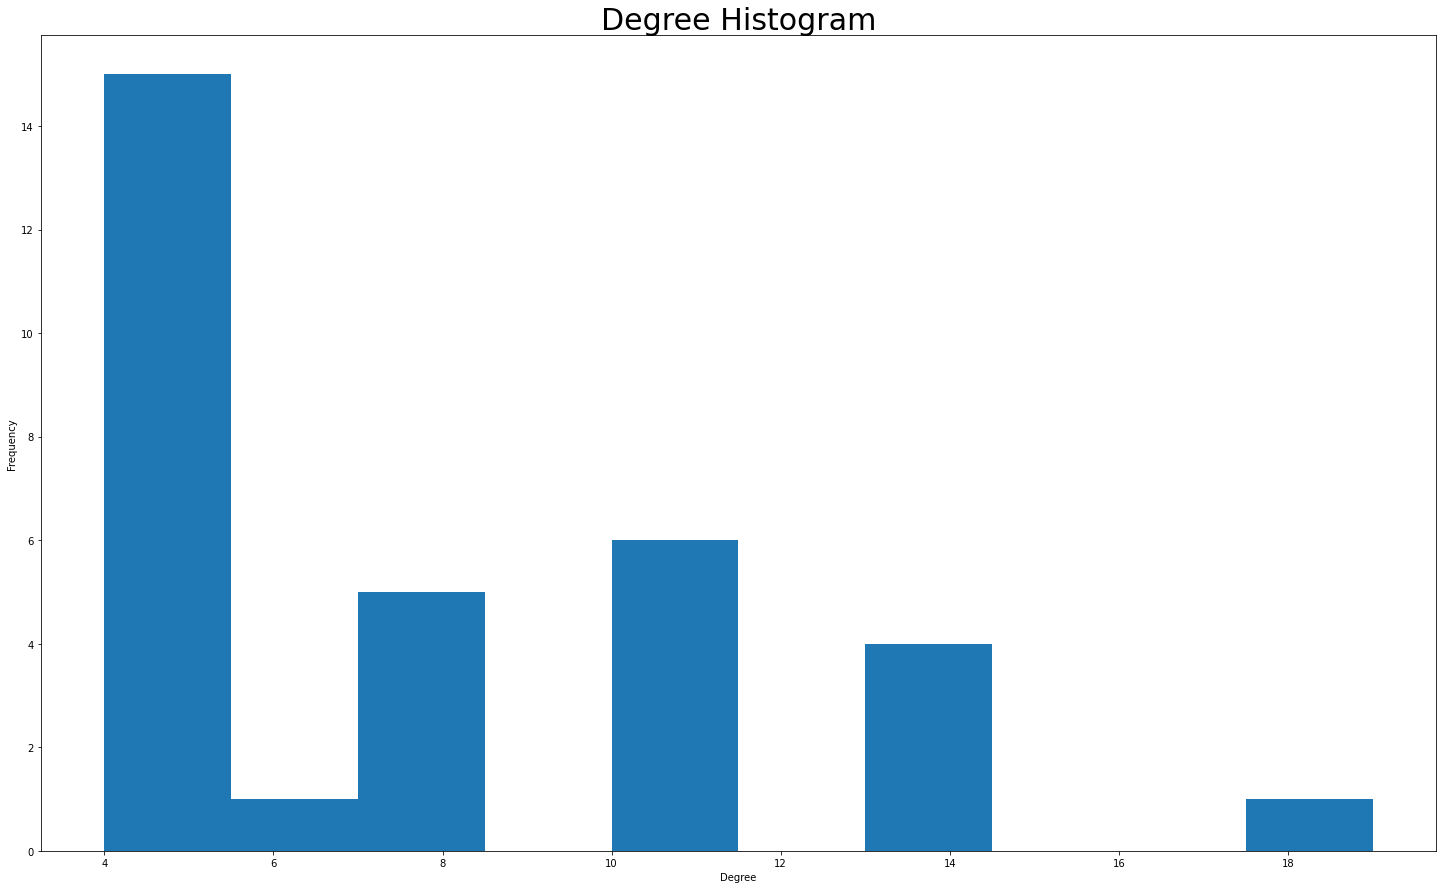

In [6]:
# Density, Connectivity, and Degree Histogram

print(nx.density(G))
print(nx.edge_connectivity(G))

degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(25, 15)) 
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Degree Histogram', fontsize=30)
plt.hist(degrees)
plt.show()

Text(0.5, 1.0, 'LoL 2023 Worlds Champion Pick Network (Play-Ins Day 1)')

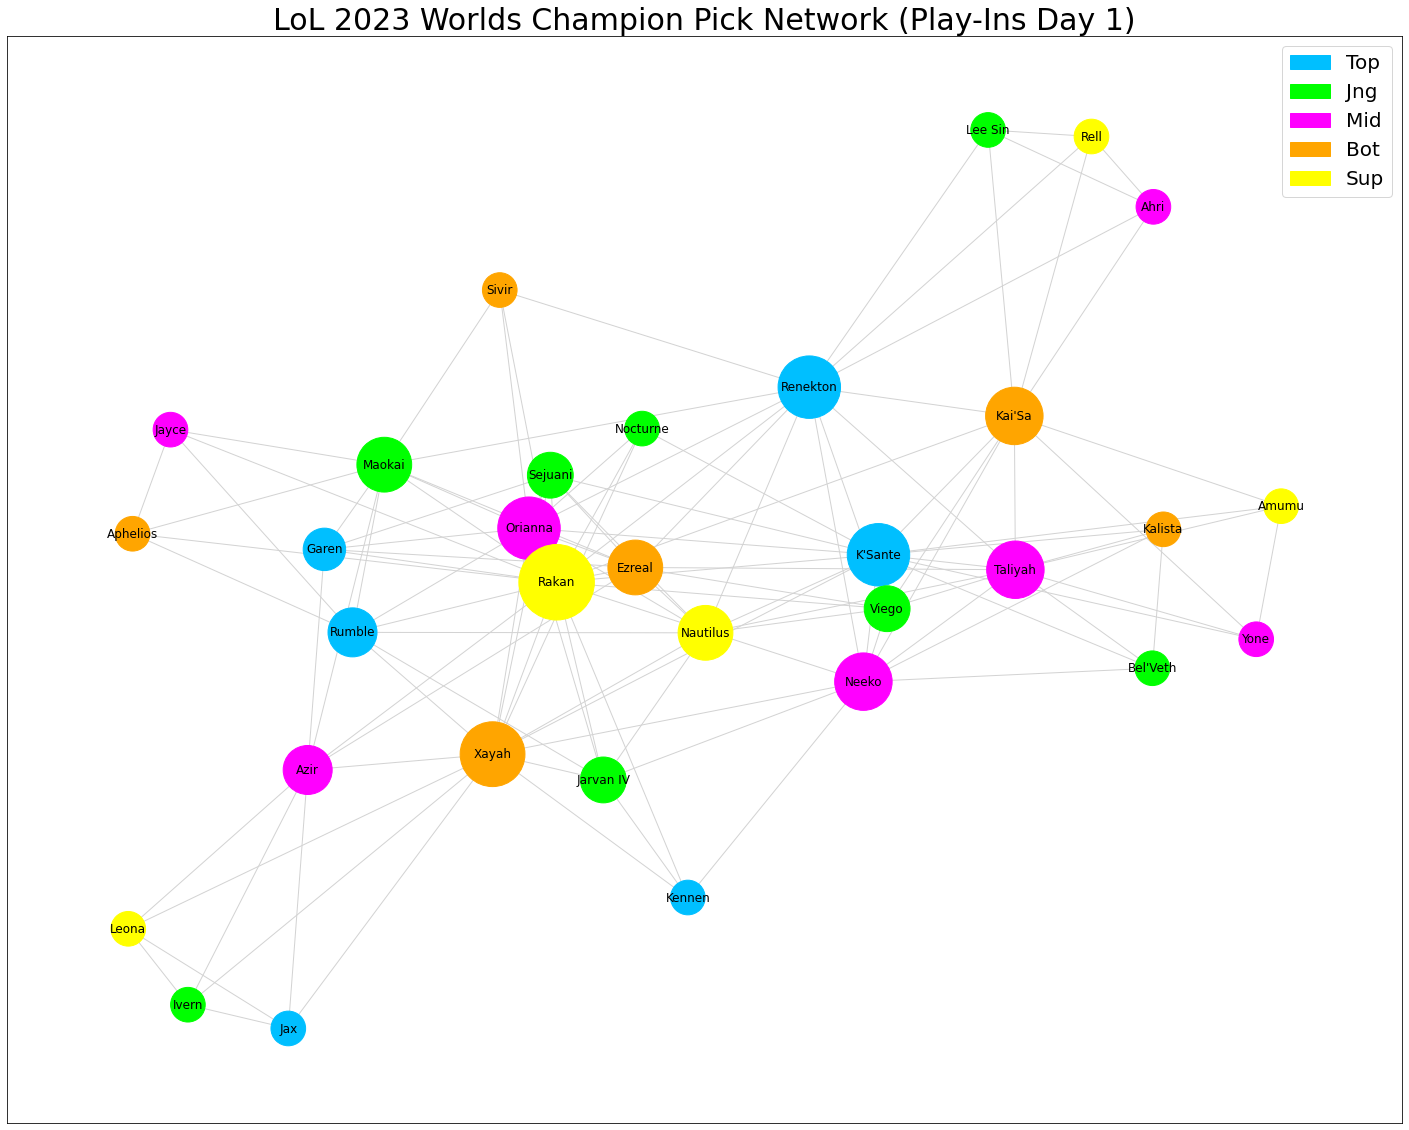

In [15]:
f = plt.figure(figsize=(25,20))
f.tight_layout()

color_map = [roles.get(node) for node in G.nodes()]

# change the scalar(x) in "v * x" to change the size of the nodes apprortiate to the size of the data
nx.draw_networkx(G, pos=nx.spring_layout(G, seed = 8), with_labels=True, node_size=[v * 300 for v in d.values()], node_color = color_map, edge_color = 'lightgrey')
# Change node size scalar if scope is smaller (team) or larger (region)

# Manually adding legend
patch1 = mpatches.Patch(color='deepskyblue', label='Top')
patch2 = mpatches.Patch(color='lime', label='Jng')
patch3 = mpatches.Patch(color='magenta', label='Mid')
patch4 = mpatches.Patch(color='orange', label='Bot')
patch5 = mpatches.Patch(color='yellow', label='Sup')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], fontsize="20")

# Change title if there's no scope
# plt.title('LoLPro Champion Network (' + scope + ')', fontsize=30)
plt.title('LoL 2023 Worlds Champion Pick Network (Play-Ins Day 1)', fontsize=30)


In [8]:
# Assigning portraits to each node
portraits = {}
for node in G.nodes():
    portraits[node] = 'LolPortraits/'+(node + "Square").replace(" ", "_")+".png"
    
for i in G.nodes():
    img = mpimg.imread(portraits[i])
    G.add_node(i,image= img)

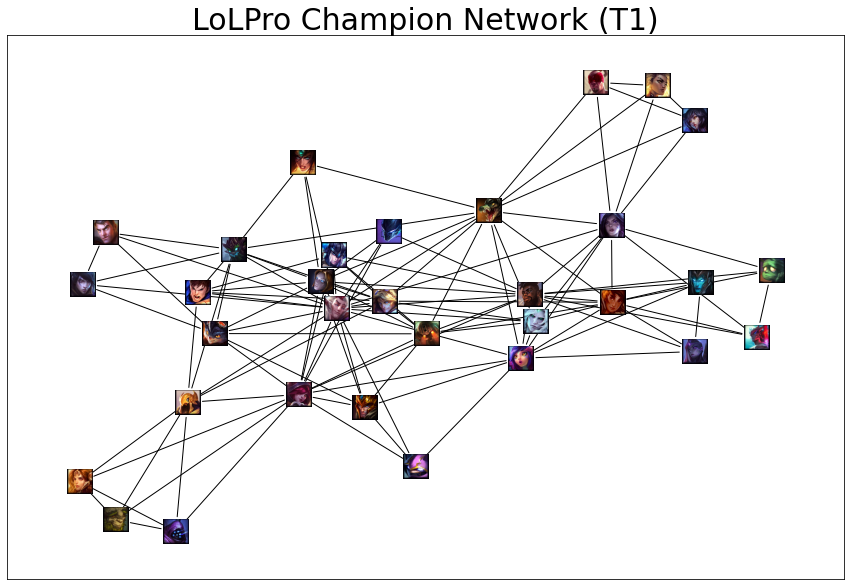

In [9]:
# Places images on node locations in graph.

fig=plt.figure(figsize=(15,10))
ax=plt.subplot(111)

# Change title if there's no scope
plt.title('LoLPro Champion Network (' + scope + ')', fontsize=30)
# plt.title('LoLPro Champion Network (LCS, LEC, LCK, LPL)', fontsize=30)

pos = nx.spring_layout(G, seed = 8)
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax = ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)
tr_figure = ax.transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.015 # Change float to change image size
icon_center = icon_size / 2.0
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(G.nodes[n]["image"])
    a.axis("off")
    
plt.show()


In [10]:
# Centrality
c_degree = pd.DataFrame(list(nx.degree_centrality(G).items()), columns = ['Champion', 'Degree_Centrality'])
c_eigen = pd.DataFrame(list(nx.eigenvector_centrality(G).items()), columns = ['Champion', 'Eigen_Centrality'])
c_between = pd.DataFrame(list(nx.betweenness_centrality(G).items()), columns = ['Champion', 'Betweenness_Centrality'])
PgRank = pd.DataFrame(list(nx.pagerank(G, alpha = 0.9).items()), columns = ['Champion', 'PageRank'])


C = c_degree.merge(c_eigen, how='inner', on='Champion')
C = C.merge(c_between, how='inner', on='Champion')
C = C.merge(PgRank, how='inner', on='Champion')
C = C.sort_values(by=['Degree_Centrality'], ascending=False)
C.head(15)

# Open in Excel to easily sort and look at top champions easier
# C.to_csv('centrality.csv', index=False)


,Champion,Degree_Centrality,Eigen_Centrality,Betweenness_Centrality,PageRank
9,Rakan,0.612903,0.371482,0.222362,0.074654
19,Xayah,0.451613,0.263451,0.153530,0.056979
0,K'Sante,0.419355,0.256818,0.124856,0.052596
5,Renekton,0.419355,0.260049,0.128668,0.052706
7,Orianna,0.419355,0.294201,0.048191,0.051112
3,Kai'Sa,0.354839,0.194738,0.091058,0.046187
12,Neeko,0.354839,0.230891,0.075902,0.044625
1,Taliyah,0.354839,0.202799,0.048196,0.045117
15,Ezreal,0.322581,0.237523,0.032586,0.039720
24,Nautilus,0.322581,0.237927,0.029947,0.039612


In [11]:
print(nx.prominent_group(G,5))
# Same as the nodes with the top 5 betweeness centrality.

(0.66, ['Rakan', 'Xayah', 'Renekton', "K'Sante", 'Taliyah'])
